<a href="https://colab.research.google.com/github/artorautapaa/llm-finetuning/blob/main/I%26B_Llama2_7b_Fine_Tuning_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorials, inspiration and source for code:


https://brev.dev/blog/fine-tuning-llama-2-your-own-data


https://gathnex.medium.com/fine-tuning-llama-2-llm-on-google-colab-a-step-by-step-guide-dd79a788ac16

https://mlabonne.github.io/blog/posts/Fine_Tune_Your_Own_Llama_2_Model_in_a_Colab_Notebook.html

https://www.datacamp.com/tutorial/fine-tuning-llama-2

***Change runtime type to GPU T4***

## Install libraries

1.   accelerate
2.   peft
3.   bitsandbytes
4.   transformers
5.   trl
6.   huggingface_hub





In [ ]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl
%pip install --upgrade huggingface_hub

## Import required modules from installed libraries

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from huggingface_hub import login
from datasets import (
    load_dataset,
    get_dataset_split_names
)
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer


## Login to Hugging Face hub to access Llama 2

In [ ]:
# Login to Hugging Face hub. Use access token for HF user
login()

## Define variables for model and dataset

In [ ]:
# Llama-2-7b from Hugging Face
base_model = "meta-llama/Llama-2-7b-hf"

# Eur-lex-sum law summary dataset
lex_dataset = "dennlinger/eur-lex-sum"

# Dataset language
lex_language = "english"

# Fine-tuned model
new_model = "llama-2-7b-llawma"

## Load desired dataset

In [ ]:
# Loads dataset from HF
dataset = load_dataset(lex_dataset, lex_language)

Filter out overly long texts from dataset

In [ ]:
# Maximum length for law passages
max_reference = 30000

# Filter out references over max length from  training and evaluation datasets
train_dataset = dataset['train'].filter(lambda example: len(example['reference']) < max_reference)
eval_dataset = dataset['validation'].filter(lambda example: len(example['reference']) < max_reference)

# Check size after filtering
train_dataset

Filter:   0%|          | 0/1129 [00:00<?, ? examples/s]

Filter:   0%|          | 0/187 [00:00<?, ? examples/s]

Dataset({
    features: ['celex_id', 'reference', 'summary'],
    num_rows: 14
})

Format dataset

Inspiration:
https://brev.dev/blog/fine-tuning-llama-2-your-own-data

In [ ]:
# Function for formatting dataset for fine-tuning
def dataset_formatting(example):
  text = f"### Reference: {example['reference']}\n ### Summary: {example['summary']}"
  return text

## 4-bit quantization for QLoRA

In [ ]:
compute_dtype = getattr(torch, "float16")

# Create 4-bit quantization config for QLoRA using BitsAndBytes
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

## Load the Llama 2 model from Hugging Face using 4-bit precision

In [ ]:
# Load 4-bit model using AutoModelForCausalLM into GPU memory
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load the tokenizer

In [ ]:
# Load tokenizer with AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

# Function for tokenizing prompts from dataset
def generate_and_tokenize_prompt(prompt):
  return tokenizer(dataset_formatting(prompt))

## Reformat and tokenize prompts

In [ ]:
# Create tokenized datasets for fine-tuning
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_eval_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/546 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

## Plot distribution of dataset lengths

560


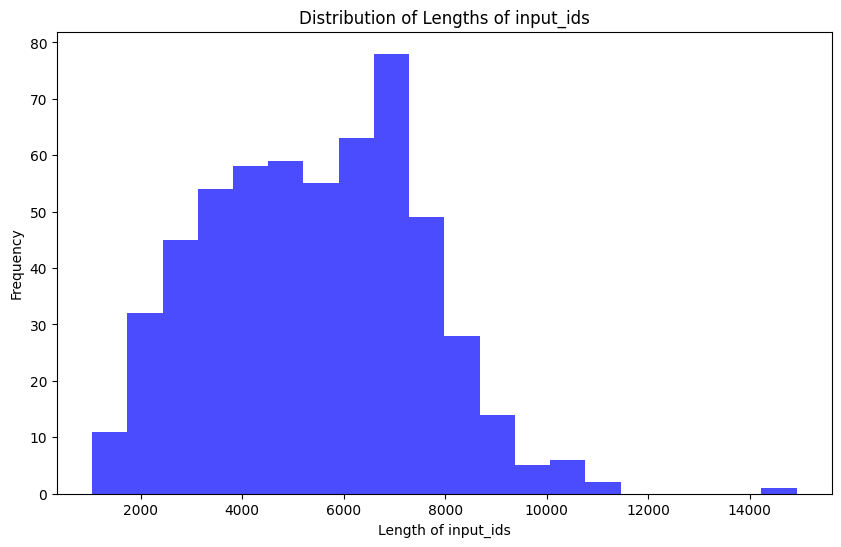

In [ ]:
# Function for plotting distribution of data lengths in dataset
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

# Plot data lengths before truncation and padding
plot_data_lengths(tokenized_train_dataset, tokenized_eval_dataset)

## Padding and truncation

In [ ]:
# Set max length for input_ids (tokenized prompts?)
max_length = 7000

# Function for tokenizing prompts while truncating and padding to max_length
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        dataset_formatting(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

Reformat, pad, truncate and tokenize prompts (takes a lot of time sometimes)

In [ ]:
# Create tokenized datasets padded and truncated to max_length
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_eval_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/546 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

560


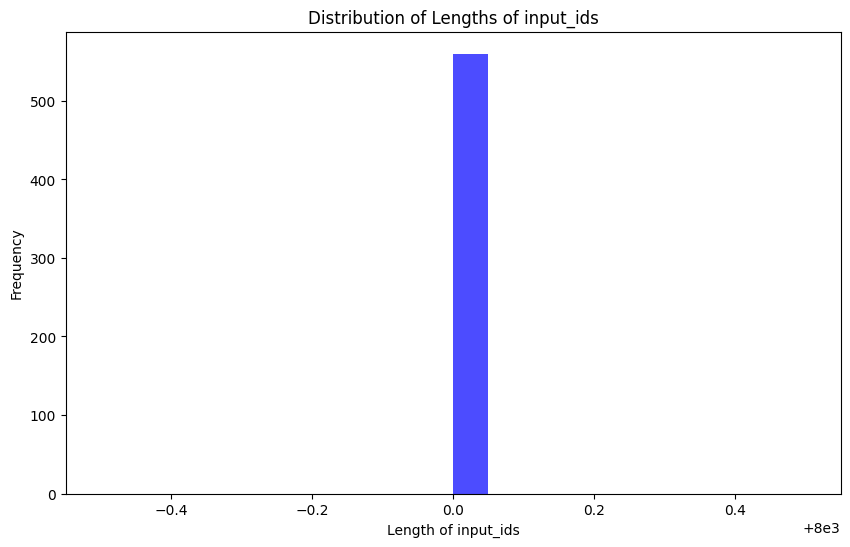

In [ ]:
# Plot distribution of data lengths to check everything is set to the same max_length
plot_data_lengths(tokenized_train_dataset, tokenized_eval_dataset)

## Evaluate base model

In [ ]:
print(eval_dataset[0]['reference'])

In [ ]:

eval_prompt = f""" Summarize the following text.

### Law: {eval_dataset[0]['reference']}

### Summary:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


OutOfMemoryError: ignored

## Define PEFT (Parameter Efficient Fine-tuning) parameters

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

## Define training parameters

In [ ]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

## Model fine-tuning using SFTTrainer (supervised fine-tuning trainer) from HuggingFace TRL library

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    peft_config=peft_params,
    dataset_text_field="summary",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1129 [00:00<?, ? examples/s]